In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widjets

import os
import time
import json
from tqdm import tqdm
from sys import getsizeof

import numpy as np
import pandas as pd
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


In [2]:
#functions to extract data

with open("markup_bboxes.json", "r") as write_file:
    data=json.load(write_file)
    
    
dict_keys = ['number', 'full_name', 'date_of_issue', 'inspection_code', 'series', 'setup_date', 'inn']
dict_keys_len = [1,3,1,1,1,1,12]
DICT_MAP = {dict_keys[i]:dict_keys_len[i] for i in range(len(dict_keys))}

def coorners_func(coords, img_shape):
    coords = (coords*[img_shape[1],img_shape[0]]).astype(np.uint16)  #[x,y]
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0)
    return x0,y0,x1,y1

def get_corners(img_num, img_shape):  #[x0,y0,x1,y1]
    layer_id = 0
    corners = np.zeros((20,4))
    for j,key in enumerate(data['collection'][img_num]['payload']['aabb'].keys()):
        for ii in range(DICT_MAP[key]):
            try:
                coords = np.array(data['collection'][img_num]['payload']['aabb'][key][ii])
                corners[layer_id] += coorners_func(coords, img_shape)
            except:
                pass
            layer_id += 1
    return corners.astype(np.uint16)

def get_masks(img_num,img_shape):
    _Corners = get_corners(img_num, img_shape)   #[x0,y0,x1,y1]
    masks = np.zeros((20,img_shape[0],img_shape[1])) # 20 is num of mask
    for i in range(len(masks)):
        x0,y0,x1,y1 = _Corners[i]
        masks[i][y0:y1,x0:x1] += 1
    return masks

def get_dataset(img_shape):
    trans = transforms.Compose([
        transforms.Resize(img_shape),
        transforms.ToTensor()
    ])
    dataset = []
    num_imgs = len(data['collection'])
    #num_imgs = 1000
    for i in tqdm(range(num_imgs), total=num_imgs):
        try:
            img_name = data['collection'][i]['input']['image'].split('/')[-1]
            IMG = Image.open('images/'+img_name)
            IMG = trans(IMG)
            masks = get_masks(i,img_shape)
            dataset.append([IMG,masks])
        except: pass
    print(f'{len(dataset)} imgs in dataset')
    
def get_images(img_shape):
    dataset_imgs = []
    dataset_corners = []
    num_imgs = len(data['collection'])
    #num_imgs = 300
    for i in tqdm(range(num_imgs), total=num_imgs):
        try:
            img_name = data['collection'][i]['input']['image'].split('/')[-1]
            IMG = Image.open('images/'+img_name).resize([img_shape[1],img_shape[0]], Image.BILINEAR) # resize to [x,y] (not [y,x] !)
            dataset_imgs.append(IMG)
            dataset_corners.append(get_corners(i,img_shape))
        except: pass
    print(f'{len(dataset_imgs)} imgs in dataset')
    return dataset_imgs, dataset_corners


class Images_Loader(torch.utils.data.Dataset):
    def __init__(self,_images,_corners, img_shape):
        super(Images_Loader, self).__init__()
        self._images, self._corners = _images,_corners
        self.transform = transforms.ToTensor()
        self._img_shape = img_shape
        
    def __len__(self):
        return len(self._images)

    def __getitem__(self, i):
        _image = self.transform(self._images[i])
        _masks = np.zeros((20,self._img_shape[0],self._img_shape[1])) # 20 is num of mask
        for j in range(20):
            x0,y0,x1,y1 = self._corners[i][j]  #[x0,y0,x1,y1]
            _masks[j][y0:y1,x0:x1] += 1
        _masks = torch.tensor(_masks).float()
        return [_image, _masks]

In [7]:
def show_part_of_img(img,coords,subplt=0):
    plt.subplot(7,1,subplt)
    coords = (coords*[img.shape[1],img.shape[0]]).astype(np.uint16)
    #print(coords)
    new_img = img[coords[0][1]:coords[2][1],coords[0][0]:coords[2][0]]
    plt.imshow(new_img)

@interact(i=(0,len(data['collection']),1))
def test_func(i=0):
    try:
        img_name = data['collection'][i]['input']['image'].split('/')[-1]
        print(img_name)
        IMG = imread('images/'+img_name)
        print(IMG.shape)
        #plt.imshow(IMG)
        print(data['collection'][i]['payload']['aabb'].keys())
        for j,key in enumerate(data['collection'][i]['payload']['aabb'].keys()):
            coords = np.array(data['collection'][i]['payload']['aabb'][key][0])
            #print(coords)
            show_part_of_img(IMG,coords,j+1)

    except:
        print('There is no such file')

interactive(children=(IntSlider(value=0, description='i', max=1227), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=118, description='i', max=1227), Output()), _dom_classes=('widget-intera…

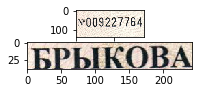

In [8]:
@interact(i=(0,len(data['collection']),1))
def test_func(i=118):
    IMG = imread('images/'+data['collection'][i]['input']['image'].split('/')[-1])
    print(IMG.shape)
    #plt.imshow(IMG)
    print(data['collection'][i]['payload']['aabb'].keys())
    for j,key in enumerate(data['collection'][i]['payload']['aabb'].keys()):
        print(data['collection'][i]['payload']['aabb'][key])
        coords = np.array(data['collection'][i]['payload']['aabb'][key][0])
        
        show_part_of_img(IMG,coords,j+1)

In [9]:
@interact(i=(0,len(data['collection']),1))
def test_func(i=118):
    IMG = imread('images/'+data['collection'][i]['input']['image'].split('/')[-1])
    print(IMG.shape)
    #plt.imshow(IMG)
    print(data['collection'][i]['payload']['aabb'].keys())
    for j,key in enumerate(data['collection'][i]['payload']['aabb'].keys()):
        print(len(data['collection'][i]['payload']['aabb'][key]))
        #coords = np.array(data['collection'][i]['payload']['aabb'][key][0])

        #show_part_of_img(IMG,coords,j+1)

interactive(children=(IntSlider(value=118, description='i', max=1227), Output()), _dom_classes=('widget-intera…

In [3]:
# описание сети
def dice_loss(pred, target, eps = 1e-10):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + eps) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + eps)))
    
    return loss.mean()


def _double_conv(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )


def _down(in_ch, out_ch):
    return nn.Sequential(
        nn.MaxPool2d(2),
        _double_conv(in_ch, out_ch)
    )


def _up(in_ch, out_ch):
    return nn.Sequential(
        _double_conv(in_ch, in_ch//2),
        nn.ConvTranspose2d(in_ch//2, out_ch, 2, stride=2)  
    )
    

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.down0 = _double_conv(3, 64)
        self.down1 = _down(64, 128)
        self.down2 = _down(128, 256)
        self.down3 = _down(256, 512)
        self.down4 = _down(512, 1024)

        self.up0 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.up1 = _up(1024,256)
        self.up2 = _up(512,128)
        self.up3 = _up(256,64)
        self.up4 = _double_conv(128, 64)
        
        self.conv_last = nn.Sequential(
            nn.Conv2d(64, n_class, 1),
            nn.Sigmoid()
        )
        
        
    def forward(self, X):
        down0 = self.down0(X)       #64
        down1 = self.down1(down0)   #128
        down2 = self.down2(down1)   #256
        down3 = self.down3(down2)   #512
        down4 = self.down4(down3)   #1024
        
        out = self.up0(down4)    #512
        out = self.up1(torch.cat([out, down3], dim=1))
        out = self.up2(torch.cat([out, down2], dim=1))
        out = self.up3(torch.cat([out, down1], dim=1))    
        out = self.up4(torch.cat([out, down0], dim=1))       #64
        
        out = self.conv_last(out)   #n_class
        
        return out
    
#from torchsummary import summary
#model = UNet(20).cuda()
#summary(model, input_size=(3,800,560))

In [4]:
#грузим модель
model = UNet(20).cuda()
try:
    model.load_state_dict(torch.load('model_0.pt'))
    print('loading weights')
except:
    print('creating new NN')
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


loading weights
cuda:0


In [5]:
#Грузим датку, ставим размер картинок         !!!!!!!! добавить аугментацию !!!!!!!!!
Y=800#16 * 40  
X=int(Y/16/297*210)*16  #A4, ужмется в 16 раз
img_shape = [Y,X]
_images, _corners = get_images(img_shape)
num_val = 20

train_dataset = Images_Loader(_images[:-num_val], _corners[:-num_val],img_shape)
val_dataset = Images_Loader(_images[-num_val:], _corners[-num_val:],img_shape)

batch_size = 2

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
}

 43%|██████████████████████████████████▏                                            | 531/1227 [00:25<00:29, 23.53it/s]c:\python37\lib\site-packages\PIL\Image.py:2618: DecompressionBombWarning: Image size (142178304 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
100%|██████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:06<00:00, 18.48it/s]


1203 imgs in dataset


In [6]:
#обучение
optimizer = optim.SGD(model.parameters(),lr=0.1,momentum=0.9,weight_decay=1e-4)

num_epochs = 60

best_loss = 1
loss_list = []
for epoch in range(num_epochs):
    print('-' * 30)
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 30)
    since = time.time()

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()

            #for inputs, true_outputs in tqdm(dataloaders[phase], total=len(dataloaders[phase])):
            for inputs, true_outputs in dataloaders[phase]:  
                inputs,true_outputs = inputs.cuda(),true_outputs.cuda()      
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    loss = dice_loss(outputs, true_outputs)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
        else:
            model.eval() 

            epoch_samples = 0
            epoch_loss = 0
            #for inputs, true_outputs in tqdm(dataloaders[phase], total=len(dataloaders[phase])):
            for inputs, true_outputs in dataloaders[phase]:
                inputs,true_outputs = inputs.cuda(),true_outputs.cuda()
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(False):
                    outputs = model(inputs)
                    loss = dice_loss(outputs, true_outputs)

                # statistics
                epoch_loss += loss.item()
                epoch_samples += 1
                    
            epoch_loss = epoch_loss/epoch_samples
            print(f'loss = {epoch_loss}')
            loss_list.append(epoch_loss)

        if phase == 'val' and epoch_loss < best_loss:
            print("saving best model")
            best_loss = epoch_loss
            torch.save(model.state_dict(), 'model_0.pt')

    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val loss: {:4f}'.format(best_loss))

------------------------------
Epoch 0/59
------------------------------
loss = 0.7885990917682648
saving best model
7m 58s
------------------------------
Epoch 1/59
------------------------------
loss = 0.7410849750041961
saving best model
7m 56s
------------------------------
Epoch 2/59
------------------------------
loss = 0.7464312732219696
7m 56s
------------------------------
Epoch 3/59
------------------------------
loss = 0.7397842466831207
saving best model
7m 55s
------------------------------
Epoch 4/59
------------------------------
loss = 0.7382768452167511
saving best model
7m 55s
------------------------------
Epoch 5/59
------------------------------
loss = 0.7375866532325744
saving best model
7m 55s
------------------------------
Epoch 6/59
------------------------------
loss = 0.7353007078170777
saving best model
7m 55s
------------------------------
Epoch 7/59
------------------------------
loss = 0.7165680706501008
saving best model
7m 55s
--------------------------

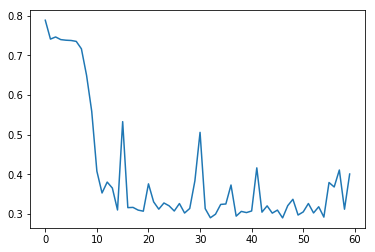

In [7]:
x = loss_list
plt.plot(x)

In [6]:
#запредиктить для картинки из val_dataset
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    #inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    return inp

inputs, true_outputs = val_dataset[0]
image_arr = reverse_transform(inputs)
inputs, true_outputs  = inputs.unsqueeze(0).cuda(), true_outputs.unsqueeze(0).cuda()
pred_outputs = model(inputs)
print(dice_loss(pred_outputs, true_outputs))


tensor(0.1708, device='cuda:0', grad_fn=<MeanBackward0>)


NameError: name 'a' is not defined

In [71]:
# посмотреть фильтры на картинке
true_outputs_arr = true_outputs.cpu().data.numpy()[0]
pred_outputs_arr = pred_outputs.cpu().data.numpy()[0]

def get_img_wfiltr(image,filtr, color):
    image = image.astype(float)
    for i_filtr in range(20):
        image[:,:,color] += filtr[i_filtr]*255*20
    image = np.clip(image, 0, 255)#.astype(np.uint8)
    return image

@interact(pred_flag=(0,1,1), true_flag=(0,1,1))
def test_func(pred_flag=1, true_flag=1):
    image = image_arr.copy().astype(float)
    
    if pred_flag:
        image = get_img_wfiltr(image, pred_outputs_arr, 0)
    
    if true_flag:
        image = get_img_wfiltr(image, true_outputs_arr, 1)
    
    image = Image.fromarray(image.astype(np.uint8))
    plt.figure(figsize=(10,10))
    plt.imshow(image)

interactive(children=(IntSlider(value=0, description='i_filtr', max=19), IntSlider(value=1, description='pred_…

In [69]:
# Посмотреть только фильтры
@interact(i=(0,19,1))
def test_func(i=0):
    
    plt.subplot(1,2,1)
    plt.title('pred')
    a = pred_outputs[0,i].cpu().data.numpy()
    plt.imshow(a)
    plt.subplot(1,2,2)
    plt.title('true')
    b = true_outputs[0,i].cpu().data.numpy()
    plt.imshow(b)
    

interactive(children=(IntSlider(value=0, description='i', max=19), Output()), _dom_classes=('widget-interact',…